# 2023 Immune dataset H3K36me3 vs RNA-seq

Benchmark according to the paper https://doi.org/10.1093/bib/bbw035
Features that define the best ChIP-seq peak calling algorithms

We considered a peak as positive if it overlaps an active gene (defined varying RPKM from 0 to 2)
and compared methods based on sensitivity, precision and F-score.

**TCell**
polyA RNAseq https://www.encodeproject.org/experiments/ENCSR763CQW/
H3K36me3 https://www.encodeproject.org/experiments/ENCSR716VIQ/
H3K4me3 https://www.encodeproject.org/experiments/ENCSR395YXN/
Control https://www.encodeproject.org/experiments/ENCSR930RIA/
**BCell**
polyA RNAseq https://www.encodeproject.org/experiments/ENCSR449GLL/
H3K4me3 https://www.encodeproject.org/experiments/ENCSR939UQD/
H3K36me3 https://www.encodeproject.org/experiments/ENCSR816NKX/
Control https://www.encodeproject.org/experiments/ENCSR300ZUS/
**CD14 monocytes**
polyA RNAseq https://www.encodeproject.org/experiments/ENCSR905LVO/
H3K4me3 https://www.encodeproject.org/experiments/ENCSR796FCS/
H3K36me3 https://www.encodeproject.org/experiments/ENCSR244XWL/
Control https://www.encodeproject.org/experiments/ENCSR444GJM/


In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from IPython.display import display
import pandas as pd
from tqdm.auto import tqdm
import seaborn as sns

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import scipy as sp
import os

In [2]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file

def d(a, b):
    return a / b if b != 0 else 0

def detect_tool(file):
    if '.narrowPeak' in file:
        return 'MACS2'
    elif '.broadPeak' in file:
        return 'MACS2 broad'
    elif '.peak' in file:
        return 'SPAN'
    else:
        return 'SICER'

## Load hg38 gtf file

In [3]:
gtf_df = pd.read_csv(os.path.expanduser(
    '~/data/2023_Immune/gencode.GRCh38.p13.v41.annotation.gtf'),
    sep='\t', comment='#',
    names=['chromosome', 'db', 'type', 'start', 'end', 'point1', 'strand', 'point2', 'aux'])
gtf_df.sample(10)

chromosome      db  type      start        end point1 strand point2  \
178204        chr1  HAVANA   UTR  147275354  147275468      .      +      .   
1220191       chr6  HAVANA  exon  145910448  145910636      .      -      .   
1738802      chr10  HAVANA   CDS   95845357   95845375      .      +      1   
1212682       chr6  HAVANA   UTR  135318519  135318616      .      -      .   
967138        chr5  HAVANA  exon   67797350   67797756      .      +      .   
1746528      chr10  HAVANA  exon   99792289   99792359      .      +      .   
1532706       chr9  HAVANA  exon    6492303    6492844      .      +      .   
1233863       chr6  HAVANA  exon  161107899  161107969      .      +      .   
2960108      chr19  HAVANA  exon   23661935   23662209      .      -      .   
1375165       chr7  HAVANA  exon  134417972  134418219      .      -      .   

                                                       aux  
178204   gene_id "ENSG00000131778.20"; transcript_id "E...  
1220191  gene_id "ENSG00000146414.17"; transcript_id "E...  
1738802  gene_id "ENSG00000138185.20"; transcript_id "E...  
1212682  gene_id "ENSG00000135541.22"; transcript_id "E...  
967138   gene_id "ENSG00000249364.7"; transcript_id "EN...  
1746528  gene_id "ENSG00000023839.12"; transcript_id "E...  
1532706  gene_id "ENSG00000147854.17"; transcript_id "E...  
1233863  gene_id "ENSG00000085511.20"; transcript_id "E...  
2960108  gene_id "ENSG00000197372.10"; transcript_id "E...  
1375165  gene_id "ENSG00000273297.4"; transcript_id "EN...

In [4]:
import re

print('Parse GTF aux data')
auxes = {}
for i, aux in enumerate(tqdm(gtf_df['aux'])):
    for pair in aux.split(';'):
        kv = pair.strip().split(' ')
        if len(kv) != 2:
            continue
        k, v = kv
        if k not in auxes:
            auxes[k] = vs = []
        else:
            vs = auxes[k]
        vs.append(v.strip('"'))

for k, vs in auxes.items():
    if len(vs) == len(gtf_df):
        gtf_df[k] = vs
    else:
        print(f'Ignoring {k}')
del auxes
gtf_df.drop('aux', axis=1, inplace=True)

# Fix . in gene_id
gtf_df['gene_id'] = [re.sub('\..*', '', id) for id in gtf_df['gene_id']]

Parse GTF aux data


  0%|          | 0/3375759 [00:00<?, ?it/s]

Ignoring hgnc_id
Ignoring havana_gene
Ignoring transcript_id
Ignoring transcript_type
Ignoring transcript_name
Ignoring transcript_support_level
Ignoring tag
Ignoring havana_transcript
Ignoring exon_number
Ignoring exon_id
Ignoring ont
Ignoring protein_id
Ignoring ccdsid
Ignoring artif_dupl


In [5]:
print(f'Total hg38 records {len(gtf_df)}')
print(f'Total hg38 genes {sum(gtf_df["type"] == "gene")}')
print(f'Total hg38 protein_coding genes {sum((gtf_df["type"] == "gene") & (gtf_df["gene_type"] == "protein_coding"))}')

gtf_genes_df = gtf_df[gtf_df['type'] == 'gene']
gtf_genes_df.sample(5)

Total hg38 records 3375759
Total hg38 genes 61852
Total hg38 protein_coding genes 20017


chromosome      db  type      start        end point1 strand point2  \
918763        chr4  HAVANA  gene  174213390  174214474      .      -      .   
125313        chr1  HAVANA  gene   68633701   68640425      .      +      .   
2148456      chr12  HAVANA  gene  119989236  120094494      .      +      .   
741013        chr3  HAVANA  gene  154827016  154861017      .      -      .   
3146229      chr21  HAVANA  gene   18917934   18935859      .      -      .   

                 gene_id       gene_type        gene_name level  
918763   ENSG00000289179          lncRNA  ENSG00000289179     2  
125313   ENSG00000285041          lncRNA  ENSG00000285041     2  
2148456  ENSG00000135127  protein_coding           BICDL1     1  
741013   ENSG00000243969          lncRNA  ENSG00000243969     2  
3146229  ENSG00000232193          lncRNA  ENSG00000232193     2

## Annotatate RNA-seq tables with positions

BCell /home/jetbrains/data/2023_Immune/expression/BCell_RNAseq_hg38_ENCFF947SKG.tsv


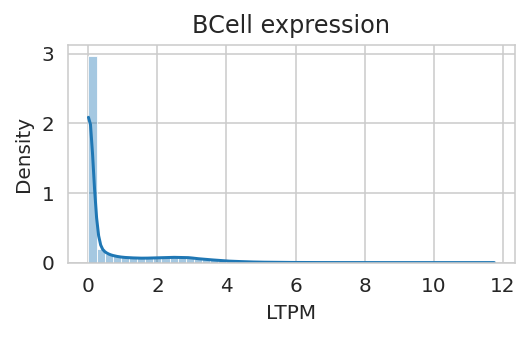

Total genes with positions 58387
Genes logTPM > 1 20769
Saved expressed genes fom BCell to /home/jetbrains/data/2023_Immune/expression/BCell_RNAseq_hg38_ENCFF947SKG_tpm1.bed
TCell /home/jetbrains/data/2023_Immune/expression/TCell_RNAseq_hg38_ENCFF502AZI.tsv


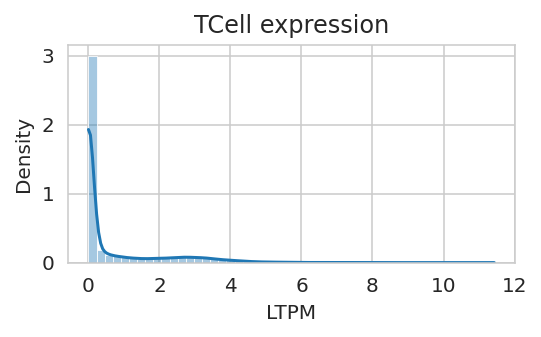

Total genes with positions 58387
Genes logTPM > 1 21110
Saved expressed genes fom TCell to /home/jetbrains/data/2023_Immune/expression/TCell_RNAseq_hg38_ENCFF502AZI_tpm1.bed
Monocyte /home/jetbrains/data/2023_Immune/expression/Monocyte_RNAseq_hg38_ENCFF408GAO.tsv


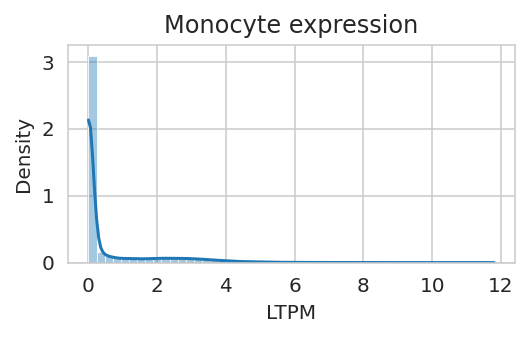

Total genes with positions 58387
Genes logTPM > 1 18584
Saved expressed genes fom Monocyte to /home/jetbrains/data/2023_Immune/expression/Monocyte_RNAseq_hg38_ENCFF408GAO_tpm1.bed


In [6]:
import re

PATH = os.path.expanduser('~/data/2023_Immune')

EXPRESSION_TSV = {
    'BCell': PATH + '/expression/BCell_RNAseq_hg38_ENCFF947SKG.tsv',
    'TCell': PATH + '/expression/TCell_RNAseq_hg38_ENCFF502AZI.tsv',
    'Monocyte': PATH + '/expression/Monocyte_RNAseq_hg38_ENCFF408GAO.tsv',
}

EXPRESSION_BED = {}

for cell, path in EXPRESSION_TSV.items():
    print(cell, path)
    t = pd.read_csv(path, sep='\t')
    # Fix . in gene_id
    t['gene_id'] = [re.sub('\..*', '', id) for id in t['gene_id']]
    t['LTPM'] = np.log1p(t['TPM'])

    # Plot expression
    plt.figure(figsize=(4, 2))
    ax = plt.axes()
    g_results = sns.histplot(data=t, x='LTPM', ax=ax,
                             stat='density',
                             bins=50, kde=True, alpha=0.4)
    ax.title.set_text(f'{cell} expression')
    plt.show()

    # Save expressed genes
    full_df = pd.merge(left=t, right=gtf_genes_df, left_on='gene_id', right_on='gene_id')
    full_df = full_df[['chromosome', 'start', 'end', 'gene_id', 'strand', 'TPM', 'LTPM']]
    full_df.sort_values(by=['chromosome', 'start'], inplace=True)

    print(f'Total genes with positions {len(full_df)}')
    full_df = full_df[full_df['LTPM'] > 0.1]
    print(f'Genes logTPM > 1 {len(full_df)}')

    # Plot expressed genes lengths
    # plt.figure(figsize=(4, 2))
    # ax = plt.axes()
    # g_results = sns.histplot(x=full_df['end']-full_df['start'], ax=ax,
    #                          stat='density',
    #                          bins=100, log_scale=True, kde=True, alpha=0.4)
    # g_results.set(xscale='log')
    # ax.title.set_text(f'{cell} genes lengths')
    # plt.show()

    expr_path = path.replace('.tsv', '_tpm1.bed')
    full_df.to_csv(expr_path, sep='\t', index=False, header=None)
    print(f'Saved expressed genes fom {cell} to {expr_path}')
    EXPRESSION_BED[cell] = expr_path


## Load peaks

In [7]:
IMMUNE_CELLS = ['BCell', 'TCell', 'Monocyte']
MODIFICATIONS = ['H3K36me3']

def load_peaks_fdr(path, suffix, fdrs):
    df_fdr = pd.DataFrame(columns=['file', 'modification', 'cell', 'fdr', 'peaks', 'avlength'],
                          dtype=object)
    for f in tqdm(os.listdir(path)):
        if suffix not in f:
            continue
        fdr = next((fdr for fdr in fdrs if fdr in f), None)
        cell = next((cc for cc in IMMUNE_CELLS if cc in f), None)
        mod = next((m for m in MODIFICATIONS if m in f), None)
        print(f, fdr, cell, mod)
        if fdr and cell and mod:
            peaks_path = os.path.join(path, f)
            ps, ls = lines(peaks_path), bedl(peaks_path)
            avls = 0 if ps == 0 else sum(ls) / ps
            df_fdr.loc[len(df_fdr)] = (f, mod, cell, fdr, ps, avls)
    return df_fdr

In [8]:
df_fdr_macs2 = load_peaks_fdr(os.path.join(PATH, 'macs2'), '.narrowPeak', ['0.05'])
df_fdr_macs2['file'] = [f'{PATH}/macs2/{f}' for f in df_fdr_macs2['file']]
df_fdr_macs2['tool'] = 'MACS2'
print('MACS2', len(df_fdr_macs2))

df_fdr_macs2broad = load_peaks_fdr(os.path.join(PATH, 'macs2'), '.broadPeak', ['0.1'])
df_fdr_macs2broad['file'] = [f'{PATH}/macs2/{f}' for f in df_fdr_macs2broad['file']]
df_fdr_macs2broad['tool'] = 'MACS2 broad'
print('MACS2 broad', len(df_fdr_macs2broad))

df_fdr_sicer = load_peaks_fdr(os.path.join(PATH, 'sicer'), 'summary-FDR', ['0.01'])
df_fdr_sicer['file'] = [f'{PATH}/sicer/{f}' for f in df_fdr_sicer['file']]
df_fdr_sicer['tool'] = 'SICER'
print('SICER', len(df_fdr_sicer))

df_fdr_span = load_peaks_fdr(os.path.join(PATH, 'span'), '.peak', ['0.05'])
df_fdr_span['file'] = [f'{PATH}/span/{f}' for f in df_fdr_span['file']]
df_fdr_span['tool'] = 'SPAN'
print('SPAN', len(df_fdr_span))

df_fdr_peaks = pd.concat([df_fdr_macs2, df_fdr_macs2broad, df_fdr_sicer, df_fdr_span])
df_fdr_peaks.sample(5)

  0%|          | 0/48 [00:00<?, ?it/s]

Monocyte_H3K4me3_hg38_ENCFF642LZZ_q0.05_peaks.narrowPeak 0.05 Monocyte None
Monocyte_H3K36me3_hg38_ENCFF164MUD_q0.05_peaks.narrowPeak 0.05 Monocyte H3K36me3
TCell_H3K4me3_hg38_ENCFF661HCG_q0.05_peaks.narrowPeak 0.05 TCell None
TCell_H3K36me3_hg38_ENCFF783YIM_q0.05_peaks.narrowPeak 0.05 TCell H3K36me3
BCell_H3K4me3_hg38_ENCFF213VRU_q0.05_peaks.narrowPeak 0.05 BCell None
BCell_H3K36me3_hg38_ENCFF207YSM_q0.05_peaks.narrowPeak 0.05 BCell H3K36me3
MACS2 3


  0%|          | 0/48 [00:00<?, ?it/s]

Monocyte_H3K4me3_hg38_ENCFF642LZZ_broad0.1_peaks.broadPeak 0.1 Monocyte None
Monocyte_H3K36me3_hg38_ENCFF164MUD_broad0.1_peaks.broadPeak 0.1 Monocyte H3K36me3
BCell_H3K36me3_hg38_ENCFF207YSM_broad0.1_peaks.broadPeak 0.1 BCell H3K36me3
BCell_H3K4me3_hg38_ENCFF213VRU_broad0.1_peaks.broadPeak 0.1 BCell None
TCell_H3K36me3_hg38_ENCFF783YIM_broad0.1_peaks.broadPeak 0.1 TCell H3K36me3
TCell_H3K4me3_hg38_ENCFF661HCG_broad0.1_peaks.broadPeak 0.1 TCell None
MACS2 broad 3


  0%|          | 0/57 [00:00<?, ?it/s]

TCell_H3K4me3_hg38_ENCFF661HCG-W200-G600-islands-summary-FDR0.01 0.01 TCell None
BCell_H3K36me3_hg38_ENCFF207YSM-W200-G600-islands-summary-FDR0.01 0.01 BCell H3K36me3
Monocyte_H3K4me3_hg38_ENCFF642LZZ-W200-G600-islands-summary-FDR0.01 0.01 Monocyte None
TCell_H3K36me3_hg38_ENCFF783YIM-W200-G600-islands-summary-FDR0.01 0.01 TCell H3K36me3
Monocyte_H3K36me3_hg38_ENCFF164MUD-W200-G600-islands-summary-FDR0.01 0.01 Monocyte H3K36me3
BCell_H3K4me3_hg38_ENCFF213VRU-W200-G600-islands-summary-FDR0.01 0.01 BCell None
SICER 3


  0%|          | 0/9 [00:00<?, ?it/s]

BCell_H3K36me3_hg38_ENCFF207YSM_200_q0.05.peak 0.05 BCell H3K36me3
Monocyte_H3K4me3_hg38_ENCFF642LZZ_200_q0.05.peak 0.05 Monocyte None
TCell_H3K4me3_hg38_ENCFF661HCG_200_q0.05.peak 0.05 TCell None
TCell_H3K36me3_hg38_ENCFF783YIM_200_q0.05.peak 0.05 TCell H3K36me3
Monocyte_H3K36me3_hg38_ENCFF164MUD_200_q0.05.peak 0.05 Monocyte H3K36me3
BCell_H3K4me3_hg38_ENCFF213VRU_200_q0.05.peak 0.05 BCell None
SPAN 3


file modification      cell  \
0  /home/jetbrains/data/2023_Immune/macs2/Monocyt...     H3K36me3  Monocyte   
0  /home/jetbrains/data/2023_Immune/span/BCell_H3...     H3K36me3     BCell   
1  /home/jetbrains/data/2023_Immune/macs2/TCell_H...     H3K36me3     TCell   
2  /home/jetbrains/data/2023_Immune/span/Monocyte...     H3K36me3  Monocyte   
0  /home/jetbrains/data/2023_Immune/macs2/Monocyt...     H3K36me3  Monocyte   

    fdr   peaks      avlength         tool  
0   0.1  105833   1881.369601  MACS2 broad  
0  0.05   28533  13428.226650         SPAN  
1  0.05  183613    881.151106        MACS2  
2  0.05   28390  13512.964882         SPAN  
0  0.05  127115   1314.086512        MACS2

In [9]:
TOOLS = ['MACS2', 'MACS2 broad', 'SICER', 'SPAN', 'Genes']
palette = plt.cm.get_cmap('tab10', len(TOOLS))
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

## Expressed genes vs peaks lengths

In [10]:
ts = []
for cell in IMMUNE_CELLS:
    t = pd.read_csv(EXPRESSION_BED[cell], sep='\t',
                    names=['chromosome', 'start', 'end', 'gene_id', 'strand', 'TPM', 'LTPM'])
    ts.append(pd.DataFrame(dict(name=['Genes'] * len(t), length=t['end']-t['start'])))
for file, tool in tqdm(zip(df_fdr_peaks['file'], df_fdr_peaks['tool'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(name=[tool] * len(lengths), length=lengths))
    ts.append(t.sample(min(len(t), 10_000)))
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

0it [00:00, ?it/s]

name  length
88827         MACS2    1811
116842  MACS2 broad    2666
23097         Genes   11485
160904         SPAN    1076
55981         Genes     530
44430         Genes    1341
134227        SICER    6999
163530         SPAN     384
33170         Genes   25024
164830         SPAN     940

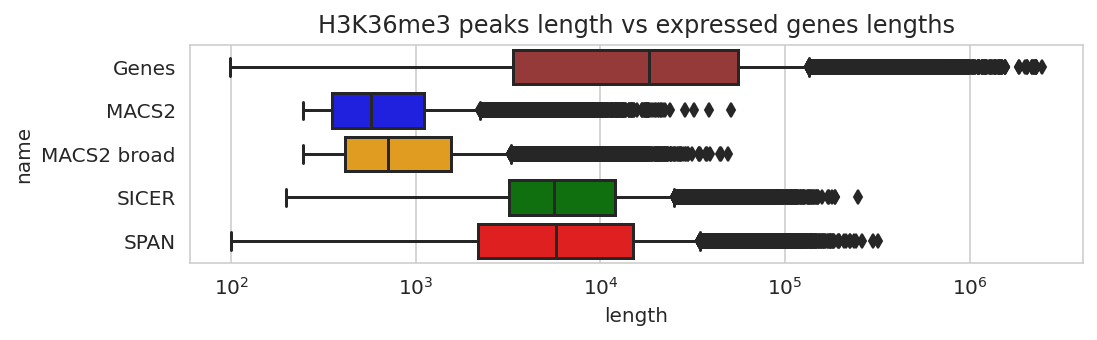

In [11]:
plt.figure(figsize=(8, 2))
ax = plt.axes()
g_results = sns.boxplot(data=t, x='length', y='name', ax=ax, palette=TOOLS_PALETTE)
g_results.set(xscale='log')
ax.title.set_text('H3K36me3 peaks length vs expressed genes lengths')
plt.show()

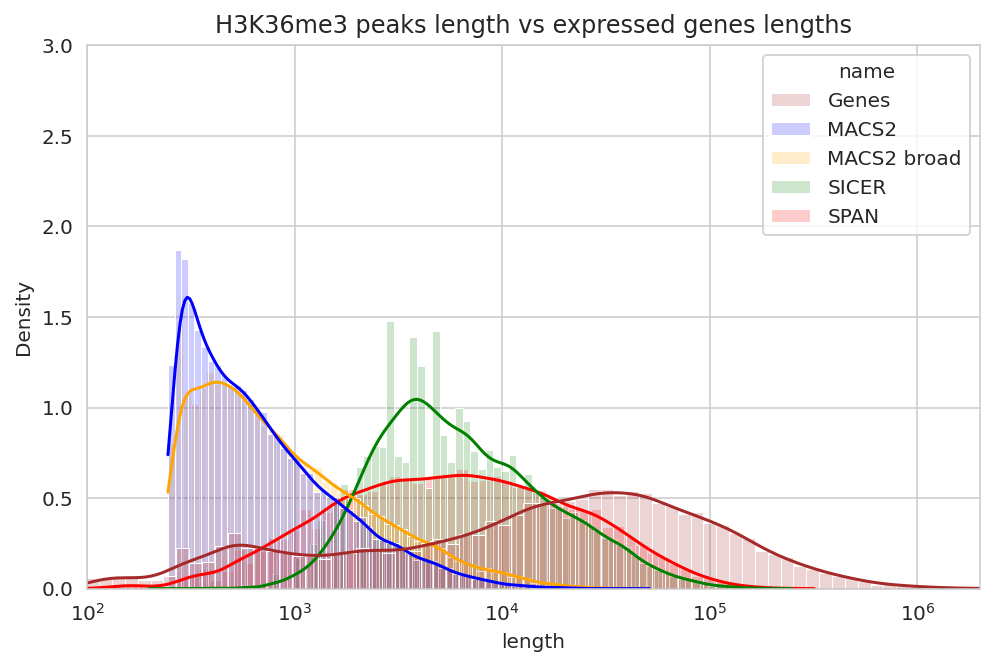

In [12]:
plt.figure(figsize=(8, 5))
ax = plt.axes()
g_results = sns.histplot(data=t, x='length', hue='name', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         kde=True, log_scale=True, alpha=0.2,
                         palette=TOOLS_PALETTE)
g_results.set(xscale='log')
g_results.set_ylim(0, 3)
g_results.set_xlim(1e2, 2e6)
ax.title.set_text('H3K36me3 peaks length vs expressed genes lengths')
plt.show()

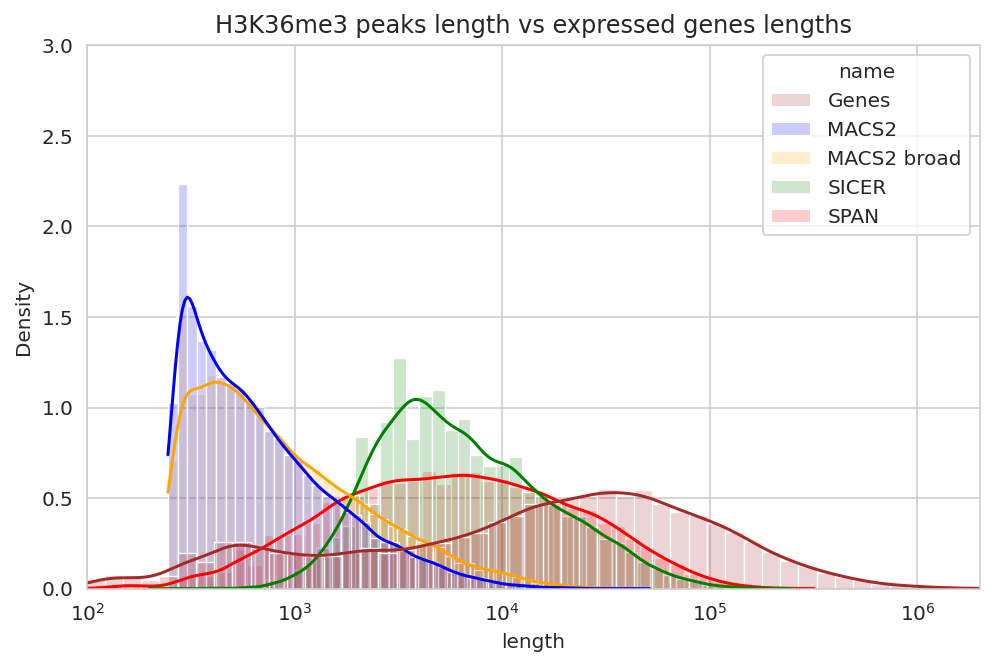

In [13]:
plt.figure(figsize=(8, 5))
ax = plt.axes()
g_results = sns.histplot(data=t, x='length', hue='name', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         bins=50, kde=True, log_scale=True, alpha=0.2,
                         palette=TOOLS_PALETTE)
g_results.set(xscale='log')
g_results.set_ylim(0, 3)
g_results.set_xlim(1e2, 2e6)
ax.title.set_text('H3K36me3 peaks length vs expressed genes lengths')
plt.show()

In [14]:
# Randomly tweak SICER lengths for visualization purposes
tsicer = t['name'] == 'SICER'
t.loc[tsicer, 'length'] += np.random.normal(0, 100, size=sum(tsicer))

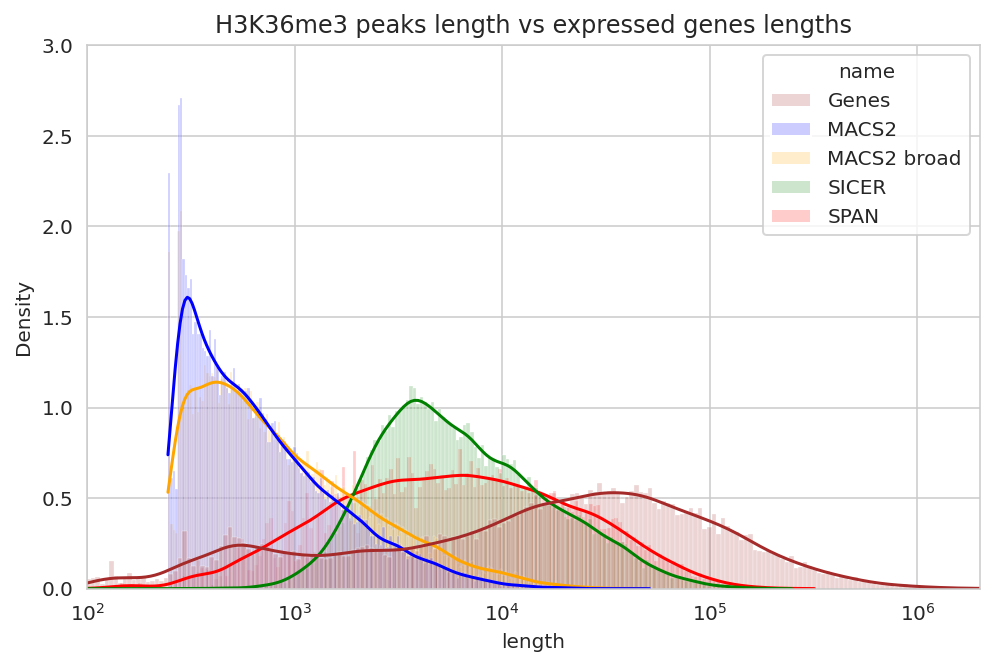

In [15]:
plt.figure(figsize=(8, 5))
ax = plt.axes()
g_results = sns.histplot(data=t, x='length', hue='name', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         bins=200, kde=True, log_scale=True, alpha=0.2,
                         palette=TOOLS_PALETTE)
g_results.set(xscale='log')
g_results.set_ylim(0, 3)
g_results.set_xlim(1e2, 2e6)
ax.title.set_text('H3K36me3 peaks length vs expressed genes lengths')
plt.show()

## Overlap H3K36me3 vs genes

In [16]:
import tempfile
from itertools import product

tf = tempfile.mktemp()

bench_df = pd.DataFrame(
    columns=['cell', 'name', 'overlap', 'peaks', 'genes', 'peaks_overlap', 'genes_overlap'],
    dtype=object
)

for c in tqdm(IMMUNE_CELLS):
    expr_file = EXPRESSION_BED[c]
    genes = lines(expr_file)
    print(f'Cell {c} genes {genes}')
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K36me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = t['file'].values[0]
        peaks = lines(peaks_file)
        for overlap, overlap_param in [
            ('1bp overlap', ''),
            ('50% overlap', ' -f 0.5 '),
            ('80% overlap', ' -f 0.8 '),
        ]:
            !bedtools intersect -a {peaks_file} -b {expr_file} -wa -u {overlap_param} > {tf}
            peaks_overlap = lines(tf)
            !bedtools intersect -b {peaks_file} -a {expr_file} -wa -u {overlap_param} > {tf}
            genes_overlap = lines(tf)
            bench_df.loc[len(bench_df)] = (c, tool, overlap, peaks, genes, peaks_overlap, genes_overlap)
bench_df

  0%|          | 0/3 [00:00<?, ?it/s]

Cell BCell genes 20769
Cell TCell genes 21110
Cell Monocyte genes 18584


cell         name      overlap   peaks  genes  peaks_overlap  \
0      BCell        MACS2  1bp overlap  177956  20769         172577   
1      BCell        MACS2  50% overlap  177956  20769         171626   
2      BCell        MACS2  80% overlap  177956  20769         170571   
3      BCell         SPAN  1bp overlap   28533  20769          27547   
4      BCell         SPAN  50% overlap   28533  20769          27074   
5      BCell         SPAN  80% overlap   28533  20769          25544   
6      BCell        SICER  1bp overlap   31862  20769          31183   
7      BCell        SICER  50% overlap   31862  20769          30678   
8      BCell        SICER  80% overlap   31862  20769          28984   
9      BCell  MACS2 broad  1bp overlap  152502  20769         147125   
10     BCell  MACS2 broad  50% overlap  152502  20769         146191   
11     BCell  MACS2 broad  80% overlap  152502  20769         144881   
12     TCell        MACS2  1bp overlap  183613  21110         178040   
13     TCell        MACS2  50% overlap  183613  21110         177175   
14     TCell        MACS2  80% overlap  183613  21110         176217   
15     TCell         SPAN  1bp overlap   29652  21110          28855   
16     TCell         SPAN  50% overlap   29652  21110          28385   
17     TCell         SPAN  80% overlap   29652  21110          26924   
18     TCell        SICER  1bp overlap   32491  21110          31827   
19     TCell        SICER  50% overlap   32491  21110          31284   
20     TCell        SICER  80% overlap   32491  21110          29613   
21     TCell  MACS2 broad  1bp overlap  161765  21110         155914   
22     TCell  MACS2 broad  50% overlap  161765  21110         154979   
23     TCell  MACS2 broad  80% overlap  161765  21110         153704   
24  Monocyte        MACS2  1bp overlap  127115  18584         123404   
25  Monocyte        MACS2  50% overlap  127115  18584         122609   
26  Monocyte        MACS2  80% overlap  127115  18584         121552   
27  Monocyte         SPAN  1bp overlap   28390  18584          27511   
28  Monocyte         SPAN  50% overlap   28390  18584          27008   
29  Monocyte         SPAN  80% overlap   28390  18584          25460   
30  Monocyte        SICER  1bp overlap   31796  18584          31140   
31  Monocyte        SICER  50% overlap   31796  18584          30684   
32  Monocyte        SICER  80% overlap   31796  18584          29127   
33  Monocyte  MACS2 broad  1bp overlap  105833  18584         102429   
34  Monocyte  MACS2 broad  50% overlap  105833  18584         101692   
35  Monocyte  MACS2 broad  80% overlap  105833  18584         100494   

    genes_overlap  
0           12639  
1            1394  
2             677  
3           13813  
4            8097  
5            5044  
6           13190  
7            6929  
8            4227  
9           13152  
10           2139  
11           1050  
12          12674  
13           1355  
14            636  
15          13648  
16           7409  
17           4327  
18          13359  
19           6927  
20           4125  
21          13498  
22           2253  
23           1041  
24          11629  
25           1373  
26            608  
27          13456  
28           7857  
29           4580  
30          12488  
31           5877  
32           3024  
33          12042  
34           2108  
35            879

In [17]:
bench_df['precision'] = [d(a, b) for a, b in zip(bench_df['peaks_overlap'], bench_df['peaks'])]
bench_df['sensitivity'] = [d(a, b) for a, b in zip(bench_df['genes_overlap'], bench_df['genes'])]
bench_df['f1'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                  for s, p in zip(bench_df['sensitivity'], bench_df['precision'])]

In [18]:
# print('Ignore outliers')
# print(len(bench_df[bench_df['precision'] < 0.1]))
# bench_df = bench_df[bench_df['precision'] >= 0.1]

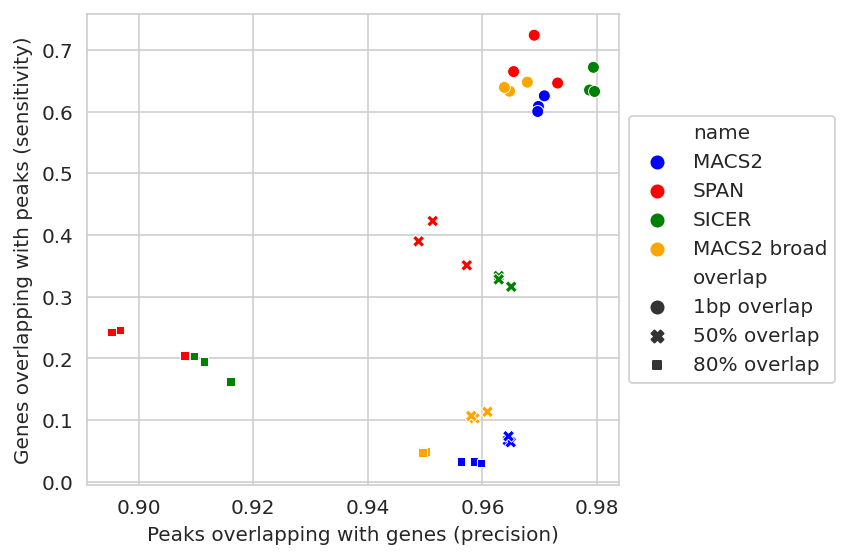

In [19]:
import seaborn as sns

plt.figure(figsize=(6, 4))
g_results = sns.scatterplot(data=bench_df, x='precision', y='sensitivity', hue='name', style='overlap',
                            palette=TOOLS_PALETTE)
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g_results.axes.set_xlabel('Peaks overlapping with genes (precision)')
g_results.axes.set_ylabel('Genes overlapping with peaks (sensitivity)')
plt.tight_layout()
plt.show()

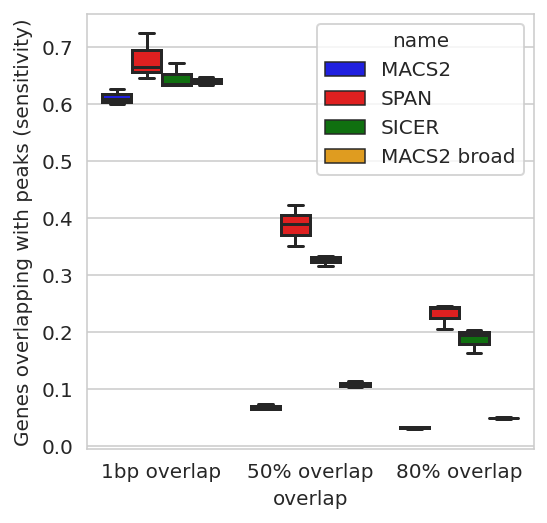

In [20]:
plt.figure(figsize=(4, 4))
g_results = sns.boxplot(data=bench_df, x='overlap', y='sensitivity', hue='name',
                        palette=TOOLS_PALETTE)
g_results.axes.set_ylabel('Genes overlapping with peaks (sensitivity)')
plt.show()

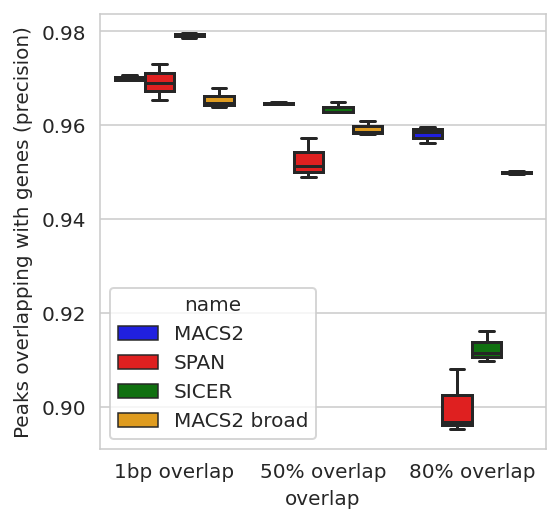

In [21]:
plt.figure(figsize=(4, 4))
g_results = sns.boxplot(data=bench_df, x='overlap', y='precision', hue='name',
                        palette=TOOLS_PALETTE)
g_results.axes.set_ylabel('Peaks overlapping with genes (precision)')
plt.show()

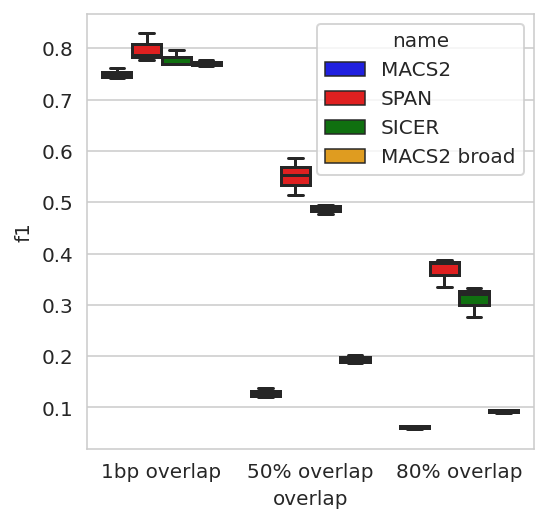

In [22]:
plt.figure(figsize=(4, 4))
sns.boxplot(data=bench_df, x='overlap', y='f1', hue='name',
            palette=TOOLS_PALETTE)
plt.show()

## Compare H3K36me3 difference of SPAN with other tools with expressed genes

In [23]:
TOOLS = list(sorted(set(bench_df['name'])))

diff_bench_df = pd.DataFrame(
    columns=['cell', 'name', 'overlap', 'peaks', 'peaks_overlap', 'genes', 'genes_overlap'],
    dtype=object
)

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()


for c in tqdm(IMMUNE_CELLS):
    print(c)
    expr_file = EXPRESSION_BED[c]
    t = df_fdr_peaks[(df_fdr_peaks['tool'] == 'SPAN') & (df_fdr_peaks['modification'] == 'H3K36me3') &
                     (df_fdr_peaks['cell'] == c)]
    if len(t) == 0:
        continue
    span_file = t['file'].values[0]
    genes = lines(expr_file)
    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K36me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = t['file'].values[0]
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')]:
            for overlap, overlap_param in [
                ('1bp overlap', ''),
                ('50% overlap', '-f 0.5'),
                ('80% overlap', '-f 0.8')
            ]:
                !bedtools intersect {args} -wa -v > {tf}
                !bedtools intersect -a {tf} -b {expr_file} -wa -u {overlap_param} > {tf2}
                peaks, peaks_overlap = lines(tf), lines(tf2)
                !bedtools intersect -b {tf} -a {expr_file} -wa -u {overlap_param} > {tf2}
                genes_overlap = lines(tf2)
                diff_bench_df.loc[len(diff_bench_df)] = \
                    (c, name, overlap, peaks, peaks_overlap, genes, genes_overlap)

display(diff_bench_df.head())

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
TCell
Monocyte


cell          name      overlap  peaks  peaks_overlap  genes  \
0  BCell  SPAN - MACS2  1bp overlap   7504           6969  20769   
1  BCell  SPAN - MACS2  50% overlap   7504           6923  20769   
2  BCell  SPAN - MACS2  80% overlap   7504           6858  20769   
3  BCell  MACS2 - SPAN  1bp overlap    252            217  20769   
4  BCell  MACS2 - SPAN  50% overlap    252            215  20769   

   genes_overlap  
0           3252  
1            101  
2             60  
3            222  
4              1

In [24]:
diff_bench_df['precision'] = [d(a, b) for a, b in zip(diff_bench_df['peaks_overlap'], diff_bench_df['peaks'])]
diff_bench_df['sensitivity'] = [d(a, b) for a, b in zip(diff_bench_df['genes_overlap'], diff_bench_df['genes'])]
diff_bench_df['f1'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                  for s, p in zip(diff_bench_df['sensitivity'], diff_bench_df['precision'])]

In [25]:
full_diff_bench_df = pd.concat([bench_df[['cell', 'name', 'peaks', 'overlap', 'precision', 'sensitivity']],
                                diff_bench_df[['cell', 'name', 'peaks', 'overlap', 'precision', 'sensitivity']]]).reset_index(drop=True)
full_diff_bench_df

cell          name   peaks      overlap  precision  sensitivity
0      BCell         MACS2  177956  1bp overlap   0.969773     0.608551
1      BCell         MACS2  177956  50% overlap   0.964429     0.067119
2      BCell         MACS2  177956  80% overlap   0.958501     0.032597
3      BCell          SPAN   28533  1bp overlap   0.965444     0.665078
4      BCell          SPAN   28533  50% overlap   0.948866     0.389860
..       ...           ...     ...          ...        ...          ...
85  Monocyte  SPAN - SICER    9475  50% overlap   0.931293     0.005166
86  Monocyte  SPAN - SICER    9475  80% overlap   0.924749     0.002852
87  Monocyte  SICER - SPAN       0  1bp overlap   0.000000     0.000000
88  Monocyte  SICER - SPAN       0  50% overlap   0.000000     0.000000
89  Monocyte  SICER - SPAN       0  80% overlap   0.000000     0.000000

[90 rows x 6 columns]

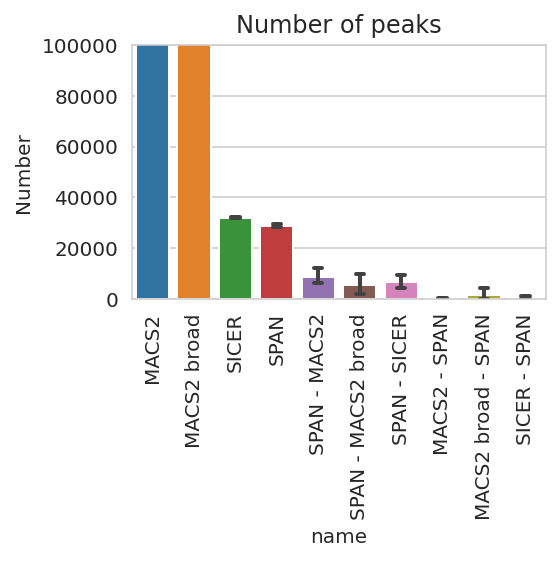

In [26]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.title.set_text('Number of peaks')
g_results = sns.barplot(data=full_diff_bench_df[full_diff_bench_df['overlap'] == '1bp overlap'], x='name', y='peaks',
                        capsize=.2, errwidth=2, ax=ax,
                        order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylim(top=100_000)  # Limit for visual aesthetics
ax.set_ylabel('Number')
plt.tight_layout()
plt.show()

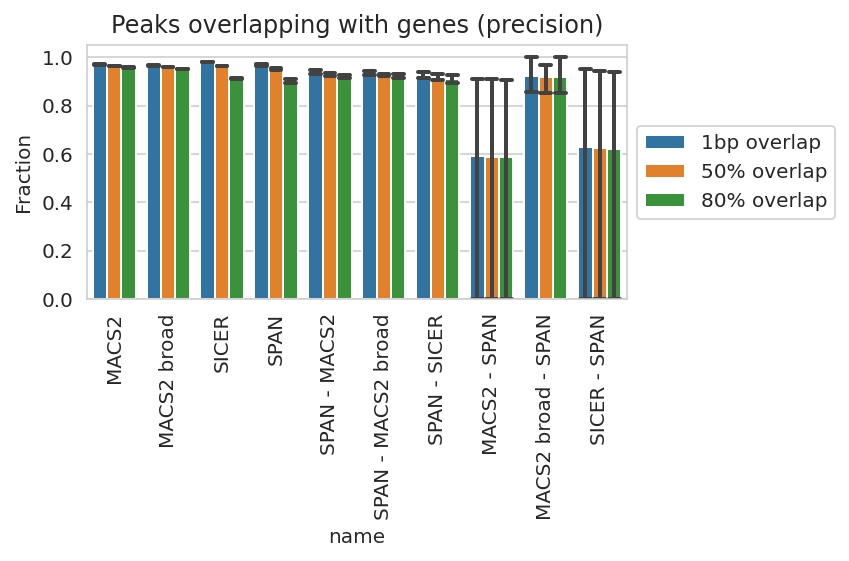

In [27]:
plt.figure(figsize=(6, 4))
ax = plt.axes()
ax.title.set_text('Peaks overlapping with genes (precision)')
g_results = sns.barplot(data=full_diff_bench_df, x='name', y='precision',
                        hue='overlap',
                        capsize=.2, errwidth=2, ax=ax,
                        order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Fraction')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

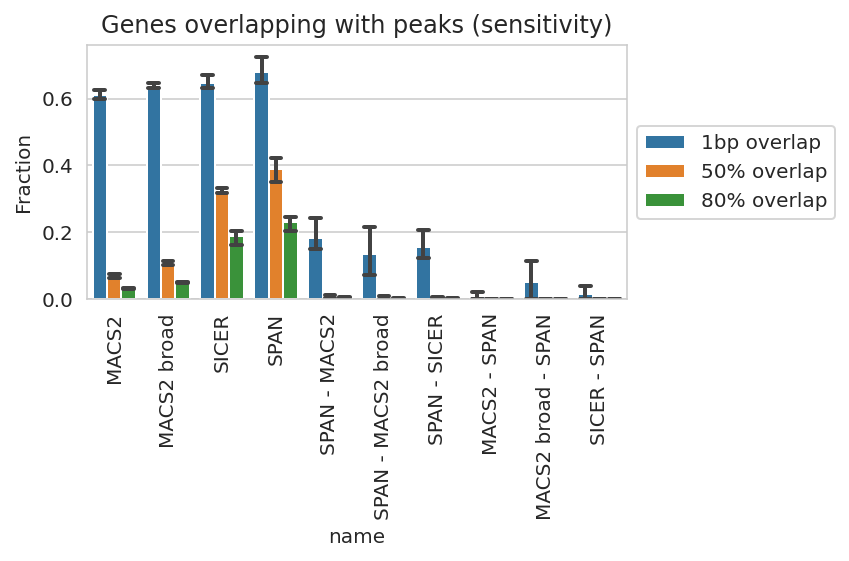

In [28]:
plt.figure(figsize=(6, 4))
ax = plt.axes()
ax.title.set_text('Genes overlapping with peaks (sensitivity)')
g_results = sns.barplot(data=full_diff_bench_df, x='name', y='sensitivity',
                        hue='overlap',
                        capsize=.2, errwidth=2, ax=ax,
                        order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Fraction')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

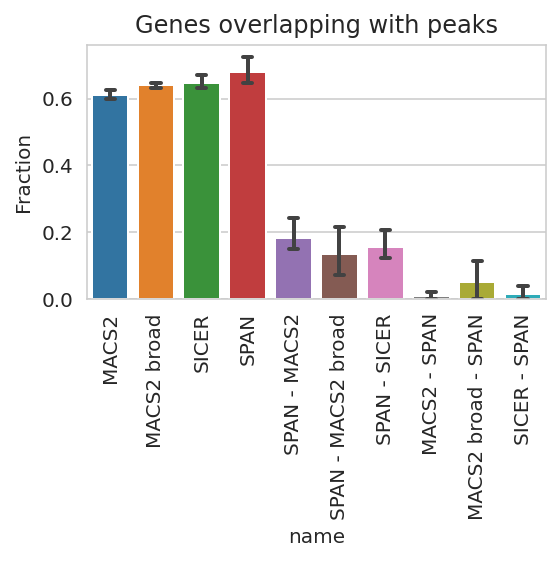

In [29]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.title.set_text('Genes overlapping with peaks')
g_results = sns.barplot(data=full_diff_bench_df[full_diff_bench_df['overlap'] == '1bp overlap'], x='name', y='sensitivity',
                        capsize=.2, errwidth=2, ax=ax,
                        order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Fraction')
plt.tight_layout()
plt.show()

## Compare genes expression overlapping peaks

In [30]:
import tempfile
from itertools import product

tf = tempfile.mktemp()

ts = []

for c in tqdm(IMMUNE_CELLS):
    print(c)
    expr_file = EXPRESSION_BED[c]
    genes = lines(expr_file)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K36me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = t['file'].values[0]

        for overlap, overlap_param in [
            ('1bp overlap', ''),
            ('50% overlap', ' -f 0.5 '),
            ('80% overlap', ' -f 0.8 ')
        ]:
            !bedtools intersect -a {expr_file} -b {peaks_file} -wa -u {overlap_param} > {tf}
            tf_expression = pd.read_csv(tf, sep='\t',
                                        names=['chromosome', 'start', 'end', 'gene_id', 'strand', 'expression']
                                        )[['expression']].copy()
            tf_expression['name'] = tool
            tf_expression['overlap'] = overlap
            ts.append(tf_expression)

peaks_expression = pd.concat(ts).reset_index(drop=True)

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
TCell
Monocyte


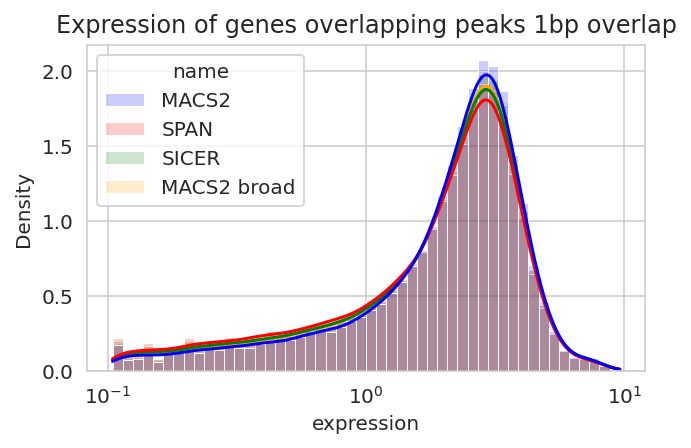

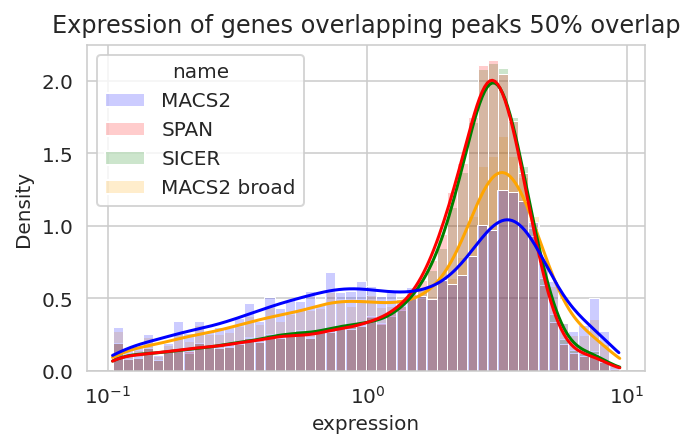

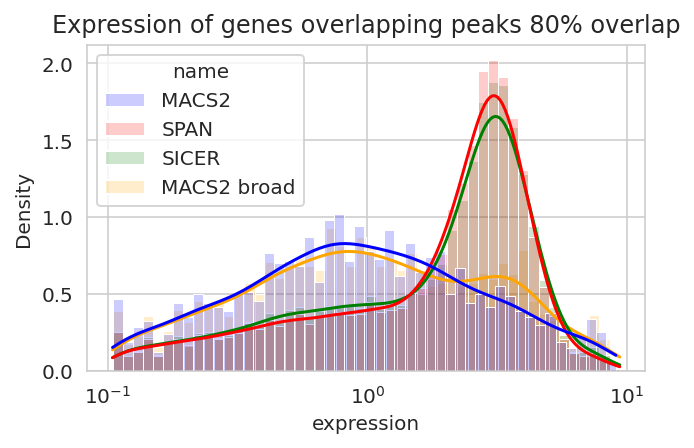

In [31]:
for overlap in peaks_expression['overlap'].unique():
    plt.figure(figsize=(5, 3))
    ax = plt.axes()
    g_results = sns.histplot(data=peaks_expression[peaks_expression['overlap']==overlap], x='expression', hue='name', ax=ax,
                             bins=50, stat='density', common_bins=False, common_norm=False,
                             kde=True, log_scale=True, alpha=0.2,
                             palette=TOOLS_PALETTE)
    g_results.set(xscale='log')
    ax.title.set_text(f'Expression of genes overlapping peaks {overlap}')
    plt.show()

## Compare ratio of peaks vs genes

In [32]:
import tempfile
from itertools import product

tf = tempfile.mktemp()

ratio_df = pd.DataFrame(columns=['cell', 'tool', 'genes', 'peaks'], dtype=object)

for c in tqdm(IMMUNE_CELLS):
    print(c)
    expr_file = EXPRESSION_BED[c]
    genes = lines(expr_file)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K36me3') &
                         (df_fdr_peaks['cell'] == c)]
        if len(t) == 0:
            continue
        peaks_file = t['file'].values[0]

        !bedtools intersect -a {expr_file} -b {peaks_file} -wa > {tf}
        tf_expression = pd.read_csv(
            tf, sep='\t',
            names=['chromosome', 'start', 'end', 'gene_id', 'strand', 'tpm', 'logTPM']
        )
        genes = len(tf_expression["gene_id"].unique())
        peaks = len(tf_expression)
        ratio_df.loc[len(ratio_df)] = (c, tool, genes, peaks)

ratio_df

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
TCell
Monocyte


cell         tool  genes   peaks
0      BCell        MACS2  12639  187450
1      BCell         SPAN  13813   33512
2      BCell        SICER  13190   37203
3      BCell  MACS2 broad  13152  160277
4      TCell        MACS2  12674  194317
5      TCell         SPAN  13648   34777
6      TCell        SICER  13359   38063
7      TCell  MACS2 broad  13498  170518
8   Monocyte        MACS2  11629  134143
9   Monocyte         SPAN  13456   33098
10  Monocyte        SICER  12488   36468
11  Monocyte  MACS2 broad  12042  111962

In [33]:
ratio_df['peaks_to_genes'] = ratio_df['peaks'] / ratio_df['genes']
ratio_df.sort_values(by=['tool'], inplace=True)

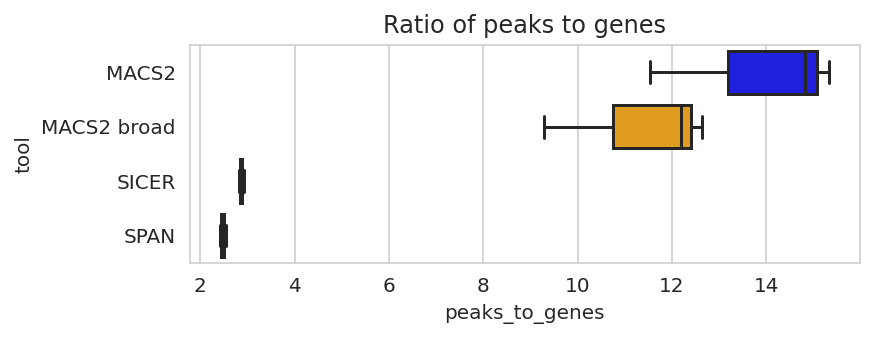

In [34]:
plt.figure(figsize=(6, 2))
ax = plt.axes()
g_results = sns.boxplot(data=ratio_df, x='peaks_to_genes', y='tool', ax=ax, palette=TOOLS_PALETTE)
ax.title.set_text('Ratio of peaks to genes')
plt.show()

# H3K36me3 benchmark

In [35]:
import tempfile
from itertools import product

tf = tempfile.mktemp()
expr_file = tempfile.mktemp()

benchmark_df = pd.DataFrame(
    columns=['cell', 'tpm', 'genes', 'peaks_file', 'peaks', 'pg', 'gp', 'overlap', 'tool'],
    dtype=object
)

for c in tqdm(IMMUNE_CELLS):
    print(c)
    t = pd.read_csv(EXPRESSION_TSV[c], sep='\t')
    # Fix . in gene_id
    t['gene_id'] = [re.sub('\..*', '', id) for id in t['gene_id']]
    t['LTPM'] = np.log1p(t['TPM'])
    full_df = pd.merge(left=t, right=gtf_genes_df, left_on='gene_id', right_on='gene_id')
    full_df = full_df[['chromosome', 'start', 'end', 'gene_id', 'strand', 'TPM', 'LTPM']]
    full_df.sort_values(by=['chromosome', 'start'], inplace=True)

    for tpm in np.linspace(0, 3, 7):
        print('Processing TMP', tpm)
        full_df[full_df['LTPM'] > tpm].to_csv(expr_file, sep='\t', index=False, header=None)
        genes = lines(expr_file)
        for tool in set(df_fdr_peaks['tool']):
            t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                             (df_fdr_peaks['modification'] == 'H3K36me3') &
                             (df_fdr_peaks['cell'] == c)]
            if len(t) == 0:
                continue
            peaks_file = t['file'].values[0]
            peaks = lines(peaks_file)
            for overlap, overlap_param in [
                ('1bp overlap', ''),
                ('50% overlap', ' -f 0.5 ')
            ]:
                !bedtools intersect -a {peaks_file} -b {expr_file} -wa -u {overlap_param} > {tf}
                peaks_overlap = lines(tf)
                !bedtools intersect -b {peaks_file} -a {expr_file} -wa -u {overlap_param} > {tf}
                genes_overlap = lines(tf)
                benchmark_df.loc[len(benchmark_df)] = \
                    (c, tpm, genes, peaks_file, peaks, peaks_overlap, genes_overlap, overlap, tool)

benchmark_df

  0%|          | 0/3 [00:00<?, ?it/s]

BCell
Processing TMP 0.0
Processing TMP 0.5
Processing TMP 1.0
Processing TMP 1.5
Processing TMP 2.0
Processing TMP 2.5
Processing TMP 3.0
TCell
Processing TMP 0.0
Processing TMP 0.5
Processing TMP 1.0
Processing TMP 1.5
Processing TMP 2.0
Processing TMP 2.5
Processing TMP 3.0
Monocyte
Processing TMP 0.0
Processing TMP 0.5
Processing TMP 1.0
Processing TMP 1.5
Processing TMP 2.0
Processing TMP 2.5
Processing TMP 3.0


cell  tpm  genes                                         peaks_file  \
0       BCell  0.0  28279  /home/jetbrains/data/2023_Immune/macs2/BCell_H...   
1       BCell  0.0  28279  /home/jetbrains/data/2023_Immune/macs2/BCell_H...   
2       BCell  0.0  28279  /home/jetbrains/data/2023_Immune/span/BCell_H3...   
3       BCell  0.0  28279  /home/jetbrains/data/2023_Immune/span/BCell_H3...   
4       BCell  0.0  28279  /home/jetbrains/data/2023_Immune/sicer/BCell_H...   
..        ...  ...    ...                                                ...   
163  Monocyte  3.0   4076  /home/jetbrains/data/2023_Immune/span/Monocyte...   
164  Monocyte  3.0   4076  /home/jetbrains/data/2023_Immune/sicer/Monocyt...   
165  Monocyte  3.0   4076  /home/jetbrains/data/2023_Immune/sicer/Monocyt...   
166  Monocyte  3.0   4076  /home/jetbrains/data/2023_Immune/macs2/Monocyt...   
167  Monocyte  3.0   4076  /home/jetbrains/data/2023_Immune/macs2/Monocyt...   

      peaks      pg     gp      overlap         tool  
0    177956  173022  13549  1bp overlap        MACS2  
1    177956  172103   1563  50% overlap        MACS2  
2     28533   27649  14984  1bp overlap         SPAN  
3     28533   27193   8655  50% overlap         SPAN  
4     31862   31251  14271  1bp overlap        SICER  
..      ...     ...    ...          ...          ...  
163   28390    8459   2688  50% overlap         SPAN  
164   31796   11374   3782  1bp overlap        SICER  
165   31796   10945   2160  50% overlap        SICER  
166  105833   38610   3755  1bp overlap  MACS2 broad  
167  105833   38106    801  50% overlap  MACS2 broad  

[168 rows x 9 columns]

In [36]:
benchmark_df['p'] = (benchmark_df['pg'] + benchmark_df['gp']) / 2
benchmark_df['precision'] = [d(x, y) for x, y in zip(benchmark_df['pg'], benchmark_df['peaks'])]
benchmark_df['sensitivity'] = [d(x, y) for x, y in zip(benchmark_df['gp'], benchmark_df['genes'])]
benchmark_df['f1'] = [2 / (d(1, s + 1e-10) + d(1, p + 1e-10)) for s, p in zip(benchmark_df['sensitivity'], benchmark_df['precision'])]
benchmark_df

cell  tpm  genes                                         peaks_file  \
0       BCell  0.0  28279  /home/jetbrains/data/2023_Immune/macs2/BCell_H...   
1       BCell  0.0  28279  /home/jetbrains/data/2023_Immune/macs2/BCell_H...   
2       BCell  0.0  28279  /home/jetbrains/data/2023_Immune/span/BCell_H3...   
3       BCell  0.0  28279  /home/jetbrains/data/2023_Immune/span/BCell_H3...   
4       BCell  0.0  28279  /home/jetbrains/data/2023_Immune/sicer/BCell_H...   
..        ...  ...    ...                                                ...   
163  Monocyte  3.0   4076  /home/jetbrains/data/2023_Immune/span/Monocyte...   
164  Monocyte  3.0   4076  /home/jetbrains/data/2023_Immune/sicer/Monocyt...   
165  Monocyte  3.0   4076  /home/jetbrains/data/2023_Immune/sicer/Monocyt...   
166  Monocyte  3.0   4076  /home/jetbrains/data/2023_Immune/macs2/Monocyt...   
167  Monocyte  3.0   4076  /home/jetbrains/data/2023_Immune/macs2/Monocyt...   

      peaks      pg     gp      overlap         tool        p  precision  \
0    177956  173022  13549  1bp overlap        MACS2  93285.5   0.972274   
1    177956  172103   1563  50% overlap        MACS2  86833.0   0.967110   
2     28533   27649  14984  1bp overlap         SPAN  21316.5   0.969018   
3     28533   27193   8655  50% overlap         SPAN  17924.0   0.953037   
4     31862   31251  14271  1bp overlap        SICER  22761.0   0.980824   
..      ...     ...    ...          ...          ...      ...        ...   
163   28390    8459   2688  50% overlap         SPAN   5573.5   0.297957   
164   31796   11374   3782  1bp overlap        SICER   7578.0   0.357718   
165   31796   10945   2160  50% overlap        SICER   6552.5   0.344226   
166  105833   38610   3755  1bp overlap  MACS2 broad  21182.5   0.364820   
167  105833   38106    801  50% overlap  MACS2 broad  19453.5   0.360058   

     sensitivity        f1  
0       0.479119  0.641914  
1       0.055271  0.104565  
2       0.529863  0.685107  
3       0.306057  0.463324  
4       0.504650  0.666417  
..           ...       ...  
163     0.659470  0.410462  
164     0.927870  0.516364  
165     0.529931  0.417353  
166     0.921246  0.522662  
167     0.196516  0.254260  

[168 rows x 13 columns]

In [37]:
import plotly.graph_objects as go


def plot_tpm(benchmark_df):
    tools_legend_shown = set()
    fig = go.Figure()
    for overlap in benchmark_df['overlap'].unique():
        marker = 'square' if overlap == '1bp overlap' else  'circle' if overlap == '50% overlap' else 'diamond'
        for c, t in product(IMMUNE_CELLS, df_fdr_peaks['tool'].unique()):
            dft = benchmark_df[(benchmark_df['cell'] == c) &
                               (benchmark_df['overlap'] == overlap) &
                               (benchmark_df['tool'] == t)]
            if len(dft) == 0:
                continue
            fig.add_trace(go.Scatter(
                x=dft["precision"], y=dft["sensitivity"], mode='lines+markers', name=t,
                hovertext=dft['tpm'].astype(str) + ' ' + t, marker_symbol=[marker] * len(dft),
                showlegend=t not in tools_legend_shown,
                marker_color=TOOLS_PALETTE[t],
                opacity=0.3
            ))
            tools_legend_shown.add(t)

    for overlap in set(benchmark_df['overlap']):
        marker = 'square' if overlap == '1bp overlap' else  'circle' if overlap == '50% overlap' else 'diamond'
        for c, t in product(IMMUNE_CELLS, df_fdr_peaks['tool'].unique()):
            dft = benchmark_df[(benchmark_df['tpm'] != 1.0) &
                               (benchmark_df['cell'] == c) &
                               (benchmark_df['overlap'] == overlap) &
                               (benchmark_df['tool'] == t)]
            if len(dft) == 0:
                continue
            fig.add_trace(
                go.Scatter(
                    mode='markers',
                    x=dft["precision"], y=dft["sensitivity"],
                    name=t,
                    marker=dict(color='white', size=3, line=dict(width=1), symbol=marker),
                    showlegend=False,
                    hovertext=dft['tpm'].astype(str) + ' ' + t,
                    opacity=0.3
                )
            )

    for overlap in set(benchmark_df['overlap']):
        marker = 'square' if overlap == '1bp overlap' else  'circle' if overlap == '50% overlap' else 'diamond'
        for c, t in product(IMMUNE_CELLS, df_fdr_peaks['tool'].unique()):
            dft = benchmark_df[(benchmark_df['tpm'] == 1.0) &
                               (benchmark_df['cell'] == c) &
                               (benchmark_df['overlap'] == overlap) &
                               (benchmark_df['tool'] == t)]
            if len(dft) == 0:
                continue
            fig.add_trace(
                go.Scatter(
                    mode='markers',
                    x=dft["precision"], y=dft["sensitivity"],
                    name=t,
                    marker=dict(color='white', size=10, line=dict(width=1), symbol=marker),
                    showlegend=False,
                    hovertext=dft['tpm'].astype(str) + ' ' + t
                )
            )

    # fig.update_xaxes(range=[-0.1, 1.1], title='Peaks overlapping active genes (precision)')
    # fig.update_yaxes(range=[-0.1, 1.1], title='Active genes overlapping peaks (sensitivity)')
    fig.update_xaxes(title='Peaks overlapping active genes (precision)')
    fig.update_yaxes(title='Active genes overlapping peaks (sensitivity)')

    fig.layout.template = 'plotly_white'
    fig.update_layout(
        autosize=False,
        width=1200,
        height=800,)
    fig.show()


In [38]:
plot_tpm(benchmark_df[benchmark_df['overlap'] == '1bp overlap'])

In [39]:
plot_tpm(benchmark_df[benchmark_df['overlap'] == '50% overlap'])